# Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
import warnings

from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings("ignore")
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abody\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Dataset

In [3]:
df = pd.read_csv('Data\Combined Data.csv', index_col=0)

# Check Null values

In [3]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [4]:
df.dropna(inplace=True)

# EDA (Explatory Data Analysis)

In [ ]:
print(df.describe())
print()
print("-" * 50)
print()
print(df.info())

                statement  status
count               52681   52681
unique              51073       7
top     what do you mean?  Normal
freq                   22   16343

--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


## <mark>we can see here that The target variable in our dataset is unbalanced</mark>

In [6]:
df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

# Exploration for our data and get example on each Status

In [7]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: why are you feeling so restless

Status: Bipolar
Statement: I’m falling deep into this hole.. After what I believe has been a 9 month of having an elevated mood... I’m crashing so hard right now. I haven’t smoked in 7 years and here I am, smoking again. I have no will to keep going. I can’t stop all this destructive behavior. I want to OD so bad. I want to die. I want to sleep and not wake up. I don’t know what to do anymore. Nothing seems to have a point. There’s no rhyme or reason in this life and I just want it to all stop.. I can’t keep having this happen. Even when I’m hypomanic, I still hate myself when I realize how crazy I was being... my husband just sees it as me going through an episode again... just shrugs his shoulders and tells me it will get better. It’s never going to get better. I’m going to keep cycling through this shit all my life. Up and down and up and down. Fuck. 

Status: Depression
Statement: This is not a oh poor me, I feel for every

# Feature engineering

In [8]:
# Text Length Features
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(sent_tokenize(x)))
print(df[['num_of_characters', 'num_of_sentences']].describe())

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [9]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


# Preprocessing

In [ ]:
# Rename & Lowercase Statements
df.rename(columns={'statement': 'original_statement'}, inplace=True)
df['statement'] = df['original_statement'].str.lower()

### Text Cleaning Function

In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()


,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


### Tokenization & Stemming

In [ ]:
df['tokens'] = df['statement'].apply(word_tokenize)
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)


# WordCloud per Status (Visualization)

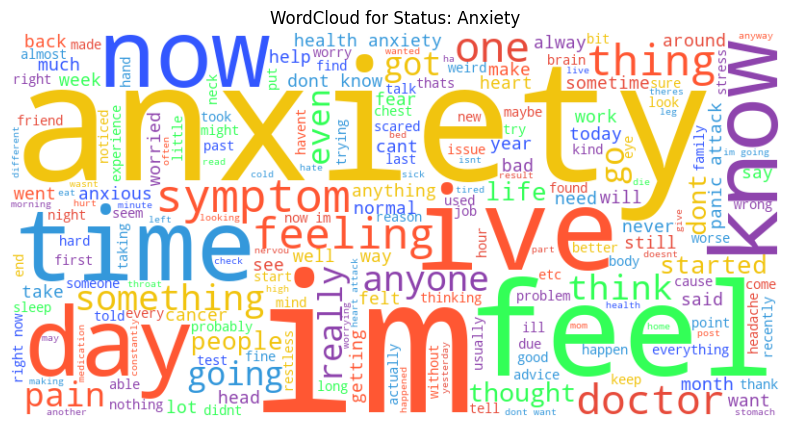

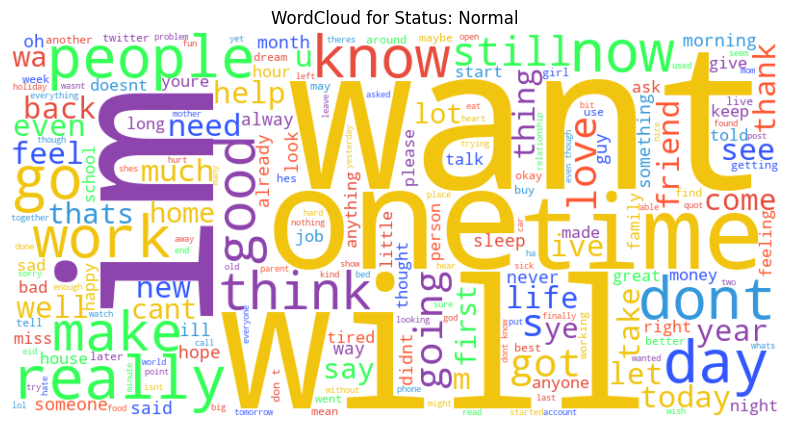

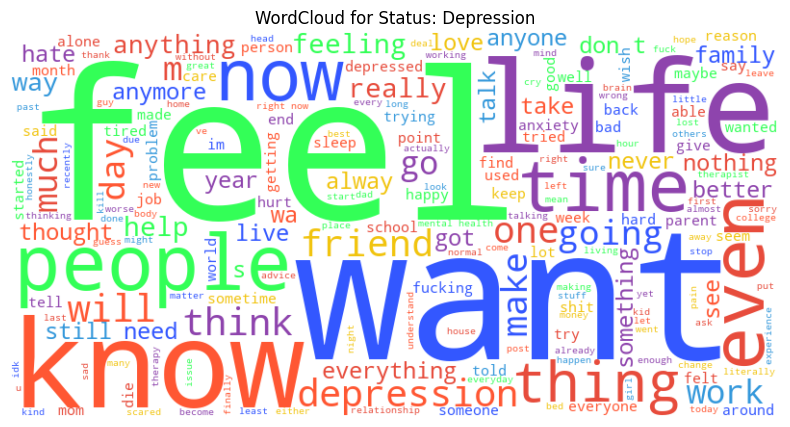

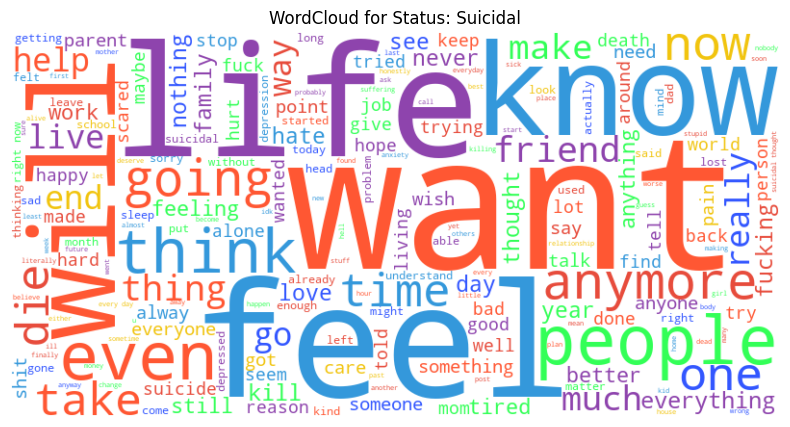

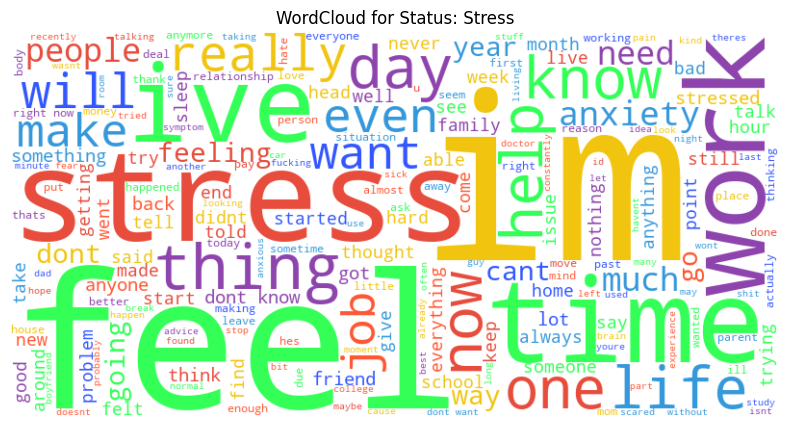

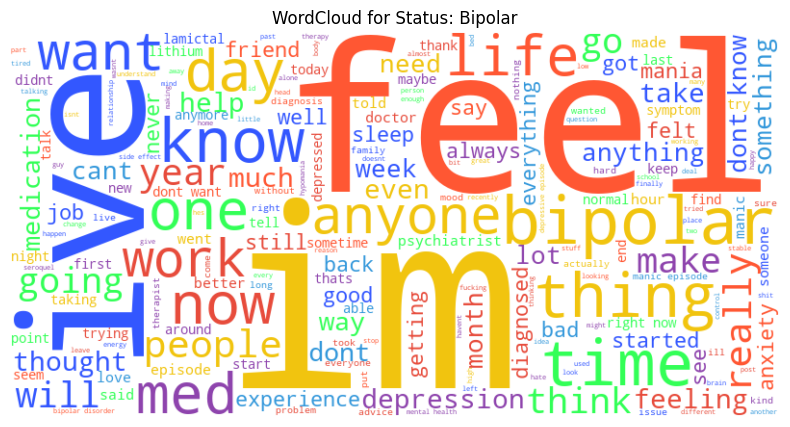

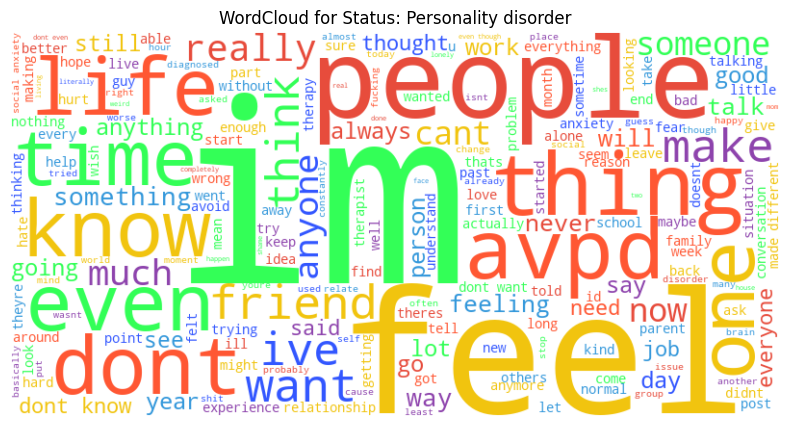

In [ ]:

colors = ['#FF5733', '#33FF57', '#3357FF', '#F1C40F', '#8E44AD', '#E74C3C', '#3498DB']
def color_func(*args, **kwargs):
    return random.choice(colors)

for status in df['status'].unique():
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].apply(lambda x: ' '.join(x)))
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

### <mark>we can see that there is overlap in the language used for discussing depression and suicidal thoughts, same words were used in both of them,this will complicate the distinction between depression and suicidal</mark>

## form that we can say that there is a strong relation between the depression and suicidal, in which most people who have suicidal thoughts are having depression 

# prepare the data

In [ ]:
# Prepare Features
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

# label encoder for out target (y)

In [15]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

# Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Vectorization

In [ ]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


## I used SMOTE, Random Over-Sampling but Random Over-Sampling show better preformance

## To handel the unbalnced data

In [18]:
# Oversample
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Model Traning and Evaluation

In [19]:
# Classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101),
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='gpu_hist')
}

accuracy_scores = []




For Decision Tree
Accuracy: 0.6184872354560121
                      precision    recall  f1-score   support

             Anxiety       0.69      0.55      0.61       768
             Bipolar       0.45      0.64      0.52       566
          Depression       0.80      0.34      0.48      3050
              Normal       0.87      0.85      0.86      3237
Personality disorder       0.58      0.43      0.49       202
              Stress       0.24      0.80      0.37       530
            Suicidal       0.52      0.66      0.58      2184

            accuracy                           0.62     10537
           macro avg       0.59      0.61      0.56     10537
        weighted avg       0.70      0.62      0.62     10537



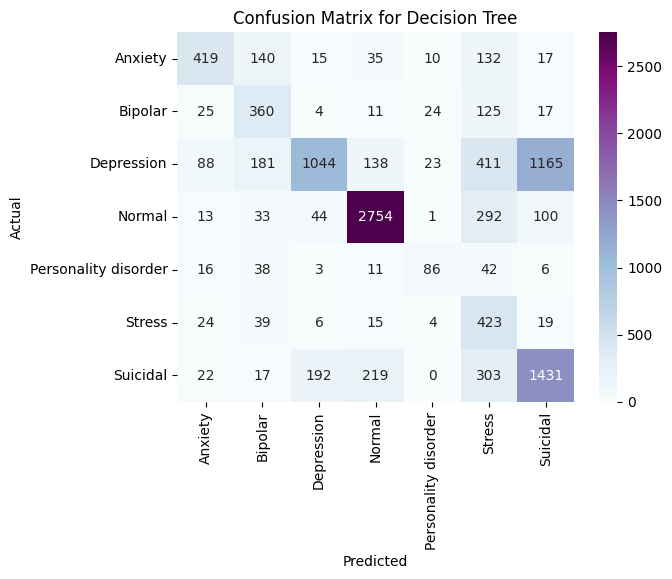



For Logistic Regression
Accuracy: 0.76321533643352
                      precision    recall  f1-score   support

             Anxiety       0.79      0.80      0.80       768
             Bipolar       0.84      0.79      0.81       566
          Depression       0.71      0.67      0.69      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.71      0.65      0.68       202
              Stress       0.60      0.65      0.62       530
            Suicidal       0.65      0.68      0.66      2184

            accuracy                           0.76     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.76      0.76      0.76     10537



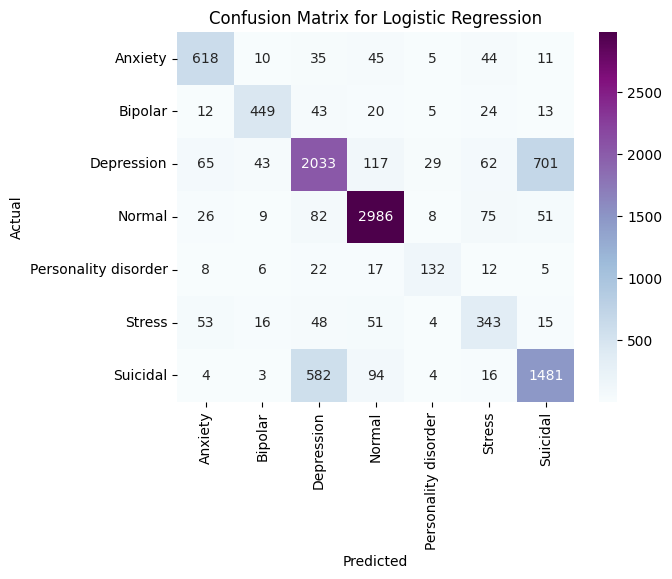



For XGB
Accuracy: 0.8080098699819683
                      precision    recall  f1-score   support

             Anxiety       0.83      0.86      0.85       768
             Bipolar       0.88      0.82      0.85       566
          Depression       0.78      0.73      0.75      3050
              Normal       0.92      0.93      0.93      3237
Personality disorder       0.84      0.65      0.74       202
              Stress       0.67      0.76      0.72       530
            Suicidal       0.69      0.73      0.71      2184

            accuracy                           0.81     10537
           macro avg       0.80      0.79      0.79     10537
        weighted avg       0.81      0.81      0.81     10537



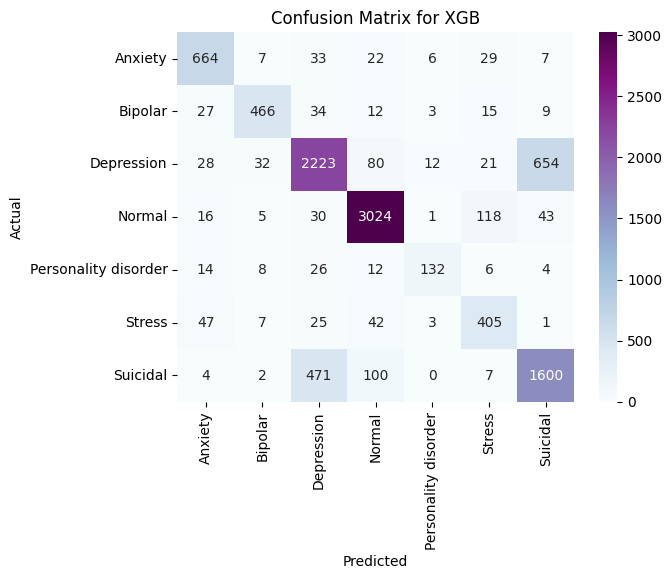

In [20]:
# Model Evaluation
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)

    # Compute the confusion matrix for the predictions
    # 'lbl_enc.classes_' provides the class labels for the confusion matrix and classification report
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))

    # Plot the confusion matrix using a heatmap
    # Annotate each cell with the numeric value of the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap

    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)


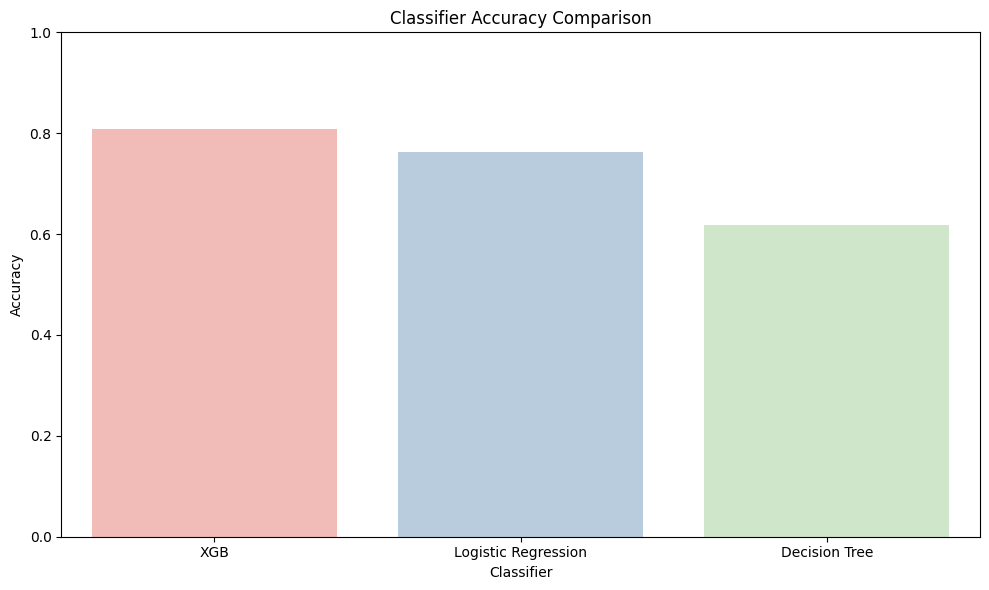

In [32]:
# Accuracy Comparison
acc_df = pd.DataFrame({'Classifier': list(classifiers.keys()), 'Accuracy': accuracy_scores}).sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='Accuracy', data=acc_df, palette='Pastel1')
plt.ylim(0, 1)
plt.title("Classifier Accuracy Comparison")
plt.tight_layout()
plt.show()

# we can see that XGB was the best model 

## save the best model(XGB)

In [5]:
import joblib
#classifiers['XGBoost'].save_model("xgb_model.json")
#joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
#joblib.dump(LabelEncoder().fit(df['status']), "label_encoder.pkl")

# Predict Function for Deployment

In [6]:
# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower() 
    text = re.sub(r'http[s]?://\S+', '', text) # Remove URLs, handles, and punctuation
    text = re.sub(r'@\w+', '', text) # Remove markdown-style links   
    text = re.sub(r'[^\w\s]', '', text) # Remove handles (that start with '@')
    tokens = word_tokenize(text) 
    stemmer = PorterStemmer()
    return ' '.join(stemmer.stem(token) for token in tokens)

# Function to predict mental health status
def predict_mental_health_status(text):
    model = XGBClassifier()
    model.load_model("Models/xgb_model.json")
    vectorizer = joblib.load("Models/tfidf_vectorizer.pkl")
    label_enc = joblib.load("Models/label_encoder.pkl")

    preprocessed = preprocess_text(text)
    tfidf = vectorizer.transform([preprocessed]) # Transform the preprocessed text
    num_feats = np.array([[len(text), len(sent_tokenize(text))]]) # Extract numerical features  
    combined = hstack([tfidf, num_feats]) # Combine TF-IDF features with numerical features
    pred = model.predict(combined)[0] 
    return label_enc.inverse_transform([pred])[0] 


# Test prediction function

In [8]:
sample_text = "i want to die"
prediction = predict_mental_health_status(sample_text)
print("Predicted Mental Health Status:", prediction)

Predicted Mental Health Status: Suicidal
